<a href="https://colab.research.google.com/github/yyocampon/PruebaTecnicaNEQUI/blob/main/PruebaTecnica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prueba técnica Científico de datos en NEQUI**

**Fecha:** 2023-08-06

**Autor:** Yeison Yovany Ocampo-Naranjo

**Objetivo:** identificar las diferentes capacidades del postulante en temas de analítica, modelamiento matemático y estadístico durante su experiencia profesional o académica.

**Actividad a realizar en la prueba:** en esta actividad nos centraremos en el evidenciamiento de una mala práctica transaccional la cual consiste en el fraccionamiento de una transacción de gran valor en múltiples transacciones de menor valor usualmente generadas en una misma ventana de tiempo que suele ser de 24 horas (a este tipo de transacciones también se les conoce como jineteo en sectores como el retail).

**Posibles riesgos:**


*   Riesgo de incumplimiento de normativa de la Superintendencia Financiera de Colombia.
*   Lavado de activos y financiación del terrorismo (LAFT).
*   Posibles prácticas fraudulentas.
*   Reputacional.



**Consideraciones y comentarios adicionadas por el postulante:** debido a la cantidad de información y los datos sintéticos, sólo se presetnará el TOP 20 en los gráficos para mayor legibilidad. Adicionalmente, por cuestiones de tiempo se usa un sólo conjunto de datos.

 <font color="#FF0000"> Las conclusiones y hallazgos se encuentran al final de la prueba, así mismo, se encuentra el flujo de datos y las justificaciones de periodicidad de la ejecución del modelo. </font>

# Actividades realizadas durante la prueba.

Durante esta prueba se realizó el análisis del conjunto de datos *sample_data_0006_part_00.parquet* el cual contiene un total de 96.825.762 registros. Con este conjunto de datos se realizó el siguiente procedimiento:



1.   Verificación de completitud de los datos y tipos de datos.
2.   Creación de variables necesarios para realizar los cálculos respectivos de día, mín, máx, promedio, cantidad de registros y cuantiles de la distribución de las variables necesarias para el análisis de datos.
3.   Generacón de gráficos de las distribuciones y cálculo de sus cuantiles para determinar posibles datos atípicos.
4. Generación de cálculos con distancia de Mahalanobis para detectar datos atípicos en función de la cantidad de transacciones por día y valor total de dichas transacciones. Inclusión de método de aprendizaje no supervisado para caracterizar posible grupos sospechosos.
5. Determinación de la frecuencia de la ejecución a través de un modelo SARIMA como argumento de su ejecución.
6.  Conclusiones y hallazgos


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# import needed libraries

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import seaborn as sns
import scipy as stats
import plotly.express as px

from scipy.stats import chi2
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


# 1. Verificación de completitud de los datos y tipos de datos.

In [4]:
# importing data set

datos = pd.read_parquet("/content/drive/MyDrive/sample_data_0006_part_00.parquet",engine='pyarrow')

In [35]:
datos.size

96825762

In [6]:
# Count number of missing values
datos.isnull().sum()

merchant_id           0
_id                   0
subsidiary            0
transaction_date      0
account_number        0
user_id               0
transaction_amount    0
transaction_type      0
dtype: int64

In [7]:
# determing type of columns in data set
datos.dtypes


merchant_id                   object
_id                           object
subsidiary                    object
transaction_date      datetime64[ns]
account_number                object
user_id                       object
transaction_amount            object
transaction_type              object
dtype: object

Observe que no se encontraron valores faltantes en el data set. Adicionalmente, note que la variable "**transaction_amount**" fue importada en formato object cuando debería ser float por ser una cantidad en pesos. También note que los valores de la variable "**transaction_type**" son CRÉDITO o DÉBITO el cual es una variable categórica.

In [34]:
datos.head(10)

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,date
0,075d178871d8d48502bf1f54887e52fe,aa8dacff663072244d0a8ab6bbe36b93,824b2af470cbe6a65b15650e03b740fc,2021-09-12 18:32:03,648e257c9d74909a1f61c54b93a9e1b3,ba42d192a145583ba8e7bf04875f837f,178.333650,CREDITO,2021-09-12
1,075d178871d8d48502bf1f54887e52fe,a53bb81bd0bba2ae2535bda7ea5a550c,2d8d34be7509a6b1262336d036fdb324,2021-09-12 18:31:58,c0b62f9046c83ea5543ea46a497a4d6e,5cfff960ea6d732c1ba3e63d24f3be52,35.666730,CREDITO,2021-09-12
2,075d178871d8d48502bf1f54887e52fe,79f893ea65c06fe2933f3847c88c272f,5eeb18254850b21af0a6bb2697913cd3,2021-09-12 18:31:56,872d10143fc0ac7d5de467806f6bef81,c97e63a92c82c7217b333635d75928ed,142.666920,CREDITO,2021-09-12
3,075d178871d8d48502bf1f54887e52fe,ce577223699dbdc119df2ab8a35457fe,5221a599856c0a0588ed9ffd150edd3b,2021-09-12 18:31:10,2e35cfe7860a480a93e1c83e99843579,fc09bdd00f283222d65eaff4d00a6594,8.322237,CREDITO,2021-09-12
4,075d178871d8d48502bf1f54887e52fe,0ce7ab2950e7a788a608f881aec0f8f0,971e55ef12d80ec070ea4f6750c8b892,2021-09-12 18:31:07,995bc89e4c4e00334f1f90c4a55f4729,213527e8ba94fcaf2f9378969f9f6abc,32.100057,CREDITO,2021-09-12
5,075d178871d8d48502bf1f54887e52fe,01220d4c4ed48cfd6f7ca5f278f9a6f6,76aca4525838053ca0d5ba8e37f1ffe8,2021-09-12 18:31:06,a32395153b2dc1383304bd2c33990a78,d1022ab075c2a2cf681398670d2bf8a1,59.444550,CREDITO,2021-09-12
6,075d178871d8d48502bf1f54887e52fe,f02cabf07366d25120c9b2e7019a4205,6b102b2df10e986bd97b1b5713be0843,2021-09-12 18:30:55,2dd7afef1abfbfbbb68b6a31df70fc91,d6b9f3858016e0581e006ad574e23c6c,11.888910,CREDITO,2021-09-12
7,075d178871d8d48502bf1f54887e52fe,fb12816c831921ff105fea2197ab26b1,3ae3115ca051e75384016f7dbe2e1c44,2021-09-12 18:30:44,b203ec1d2e5355a406451c5a664fd1fe,fed67132093416ba01a45b31d907d437,29.722275,CREDITO,2021-09-12
8,075d178871d8d48502bf1f54887e52fe,faf1f94ffdcd14b92523439672079498,408c74e90c79b159c91267b8fdf11053,2021-09-12 18:30:15,8bd7618563c9e4e9c1cee885a8816188,09e64f7c1df4eb1acd93733bc7c699a7,23.777820,CREDITO,2021-09-12
9,075d178871d8d48502bf1f54887e52fe,76d975dce75647824a3ff3d1c8e4fa4c,30e5a216a97f0b59114d79b0b69061a2,2021-09-12 18:29:45,c4703b5e8501767be83fe2b258ffc7ee,320b4b756f3584ee36738cf8cd60a581,41.611185,CREDITO,2021-09-12


# 2. Creación de variables necesarios para realizar los cálculos respectivos

In [8]:
# Converting columns to correct way

datos['transaction_amount'] = datos['transaction_amount'].astype(float)

# Creating column without especific hour to compute aggregated values

datos['date'] = pd.to_datetime(datos['transaction_date']).dt.date

In [15]:
# Aggregated data by date

dates_group = datos[['date','transaction_amount','transaction_type']].groupby(['date','transaction_type']).count()
dates_group = dates_group.reset_index()

dates_group = dates_group.set_index('date')


In [21]:
dates_group.columns = ['transaction_type','Number_Transaction_by_day']

In [16]:
dates_group.head(10)

,transaction_type,transaction_amount
date,,
2021-01-01,CREDITO,3385
2021-01-01,DEBITO,6107
2021-01-02,CREDITO,6777
2021-01-02,DEBITO,13960
2021-01-03,CREDITO,5539
2021-01-03,DEBITO,12726
2021-01-04,CREDITO,11488
2021-01-04,DEBITO,22471
2021-01-05,CREDITO,12492


In [17]:
dates_group.tail(10)

,transaction_type,transaction_amount
date,,
2021-11-26,CREDITO,9421
2021-11-26,DEBITO,35238
2021-11-27,CREDITO,7189
2021-11-27,DEBITO,33560
2021-11-28,CREDITO,2900
2021-11-28,DEBITO,26529
2021-11-29,CREDITO,10380
2021-11-29,DEBITO,33016
2021-11-30,CREDITO,8997


Observe que el conjunto de datos tiene información desde el 2021-01-01 hasta el 2021-11-30

# 3. Generación de gráficos de las distribuciones y cálculo de sus cuantiles para determinar posibles datos atípicos.

In [30]:
# Building a time series to analyze the behaivour of number of transaction by day

fig = px.line(dates_group, x = dates_group.index, y = 'Number_Transaction_by_day', title='Number of transaction by day', color='transaction_type')
fig.show()

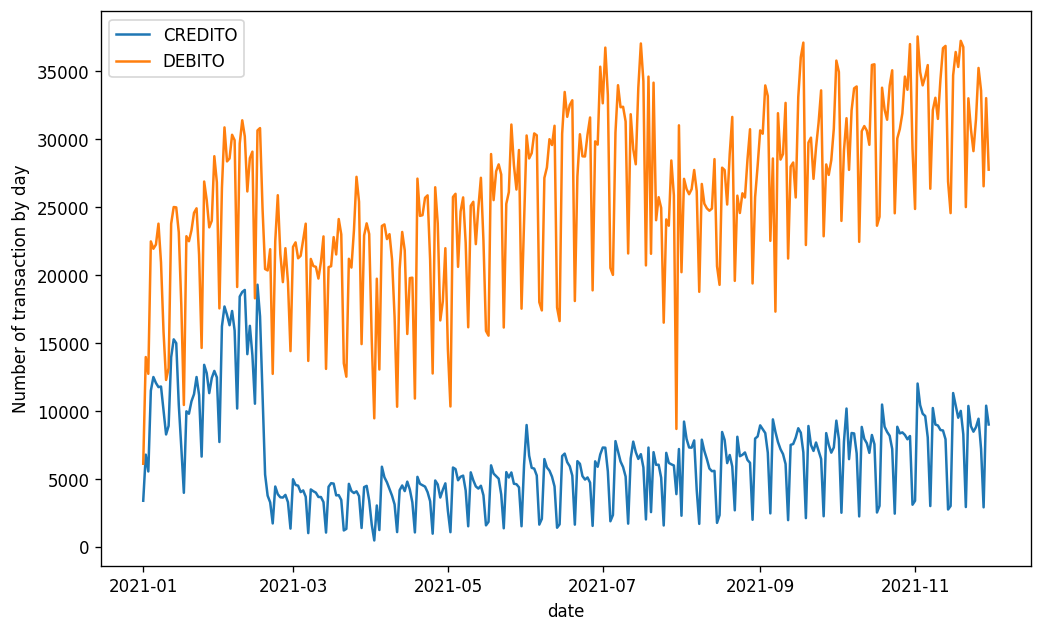

In [204]:
dates_group.groupby('transaction_type')['Number_Transaction_by_day'].plot(legend='True')
plt.ylabel('Number of transaction by day')
plt.show()

En la gráfica anterior se puede apreciar que el comportamiento diario del número de transacciones diarias qeu se reciben por naturaleza de cuenta. En esta gráfica encontramos varias situaciones interesantes:

* Antes de empezar el mes de marzo se ve un cambio significativo en el número de transacciones de tipo crédito, entre el 15 y el 19 de febrero. Adicionalmente, se encuentra una tendencia creciente del número de transacciones por día.
* Para el comportamiento diario de la cantidad de transacciones tipo débito se encuentra una tendencia creciente. Sin embargo, el 30 de julio se presentó la mayor caída desde el 01 de enero con un total de **8669 transacciones**.
* En ambas series se observa una estacionalidad semanal, es decir, se presenta un comportamiento similiar cada semana, con una tendencia a crecer, más pronunciada en la cantidad de transacciones de tipo débito que crédito.  



In [27]:
# Bulding boxplot for number of transactions by day

fig = px.box(dates_group, x = "transaction_type", y="Number_Transaction_by_day", points="outliers")
fig.show()

<Axes: xlabel='transaction_type', ylabel='Number_Transaction_by_day'>

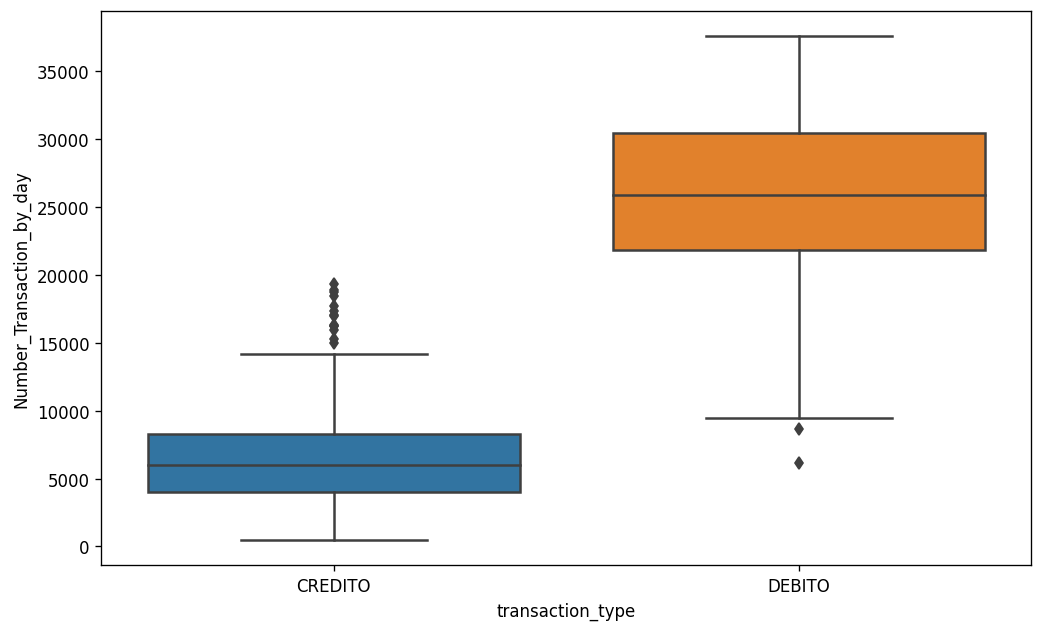

In [205]:
sns.boxplot(x='transaction_type', y='Number_Transaction_by_day', data=dates_group)

In [32]:
# Descriptive  metrics
dates_group.groupby('transaction_type').describe()

Number_Transaction_by_day                                     \
                                     count          mean          std     min   
transaction_type                                                                
CREDITO                              334.0   6488.410180  3632.232363   461.0   
DEBITO                               334.0  25722.422156  6288.573142  6107.0   

                                                        
                       25%      50%       75%      max  
transaction_type                                        
CREDITO            4017.75   6032.0   8273.75  19285.0  
DEBITO            21831.25  25870.5  30414.75  37555.0

Observe que para el número de transacciones por día las de naturaleza débito tiene un valor mínimo de **6107 transacciones** por día con una desviación estándar de **6288.5 transacciones** aproximadamente, desviación que es mucho mayor respecto a la del número de transacciones diarias de transacciones de tipo crédito. Adicionalmente, se puede observar el número promedio de transacciones por día y la mediana son muy cercanas, cual nos habla de la simetría de la distribución del número de transacciones diarias.

Por otro lado, queda en evidencia que el número de transacciones por día es diferente en para cada tipo de transacción. En particular, se puede realizar un modelo ANOVA para validar esta diferencia.

### Se realizan agrupaciones de las variables de forma marginal (nos enfocaremos en las transacciones tipo débito)

Este análisis se realizó para el TOP 20 en cada variable que generaron mayor número de transacciones (sin importar el día)

##### Analicemos la sede o sucursal (subsidiary).

In [61]:
subsidiary_grouped = datos[['subsidiary','transaction_type','transaction_amount']].groupby(['subsidiary','transaction_type']).count().reset_index()
subsidiary_grouped_sort = subsidiary_grouped.sort_values(by=['transaction_amount'], ascending=False)
subsidiary_grouped_sort_fin = subsidiary_grouped_sort.loc[subsidiary_grouped_sort['transaction_type']=='DEBITO'].head(20)
subsidiary_grouped_sort_fin

,subsidiary,transaction_type,transaction_amount
26463,f54e0b6b32831a6307361ed959903e76,DEBITO,171737
15207,8c52a2d7745e37bcee79717300f796e3,DEBITO,80794
22893,d4b621a24cc03e3f92155a7e241fa1c3,DEBITO,74854
24099,dff70ce33784a932ce4a7efc81a43863,DEBITO,57418
22891,d4b31b123120a4eefd51ba95975f2ae4,DEBITO,21440
7577,464139dd69c67ebf50f2f946bc12513e,DEBITO,13984
8505,4ecafb5dcecd6027257e8af4d9c82853,DEBITO,11972
8580,4f511a84e8c4b1c09991e0d876e880ce,DEBITO,10092
5670,3458b243beebecf55605ca649b6b2ea5,DEBITO,7640
27458,fee20d2f0753125f11b4376da5dbad4c,DEBITO,7057


In [60]:
fig = px.bar(subsidiary_grouped_sort_fin, x='subsidiary', y='transaction_amount')
fig.show()

<BarContainer object of 20 artists>

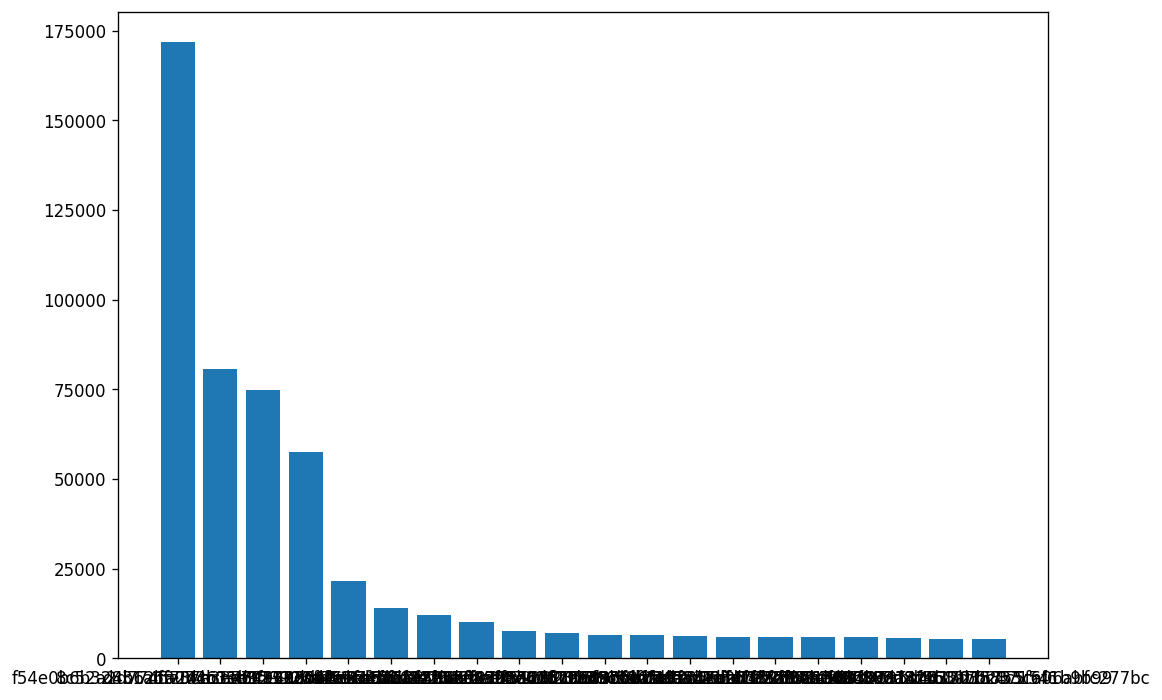

In [207]:
# Horizontal Bar Plot
fig = plt.figure(figsize =(10, 7))
plt.bar(subsidiary_grouped_sort_fin['subsidiary'], subsidiary_grouped_sort_fin['transaction_amount'])

Note que para el TOP 20 de las sedes o sucursales, se generaron por encima de 5.000 registros en el conjunto de datos. Sin embargo, se observa que el TOP 5 está por encima de las 20.000 transacciones.

##### Analicemos la comercio o aliado (merchant).

In [63]:
merchant_grouped = datos[['merchant_id','transaction_type','transaction_amount']].groupby(['merchant_id','transaction_type']).count().reset_index()
merchant_grouped_sort = merchant_grouped.sort_values(by=['transaction_amount'], ascending=False)
merchant_grouped_sort_fin = merchant_grouped_sort.loc[merchant_grouped_sort['transaction_type']=='DEBITO'].head(20)
merchant_grouped_sort_fin

,merchant_id,transaction_type,transaction_amount
3,817d18cd3c31e40e9bff0566baae7758,DEBITO,7222782
5,838a8fa992a4aa2fb5a0cf8b15b63755,DEBITO,759700
1,075d178871d8d48502bf1f54887e52fe,DEBITO,608807


Observe que sólo tres comercios o aliados tienen número de transacciones de naturaleza débito.

##### Analicemos la comercio o aliado (account number).

In [65]:
account_grouped = datos[['account_number','transaction_type','transaction_amount']].groupby(['account_number','transaction_type']).count().reset_index()
account_grouped_sort = account_grouped.sort_values(by=['transaction_amount'], ascending=False)
account_grouped_sort_fin = account_grouped_sort.loc[account_grouped_sort['transaction_type']=='DEBITO'].head(20)
account_grouped_sort_fin

,account_number,transaction_type,transaction_amount
200898,171228ac3ecfa6c797a2ac382f22fc93,DEBITO,900
423576,3094e023b7a40245397e116bddbe45e8,DEBITO,700
1632185,bb43344022157cba434a58a212ed053f,DEBITO,700
16999,01f215b451a797d8d42c1e5ee26edf82,DEBITO,573
1909775,db14b540a6f281bf032d6ddfe0282e4f,DEBITO,524
1636908,bbd2d9cbfd4a10fc3963c4094554315d,DEBITO,517
2138253,f53495dc604acd80a66c44448467cf32,DEBITO,500
684572,4e6ec6ba5dfe817108182b70ba57420e,DEBITO,500
1161193,852cf5a196377c39ccc34bfd80faf9b3,DEBITO,466
1512849,ad876e8d778b8c9b44c615b2ce85d02c,DEBITO,439


In [66]:
fig = px.bar(account_grouped_sort_fin, x='account_number', y='transaction_amount')
fig.show()

<BarContainer object of 20 artists>

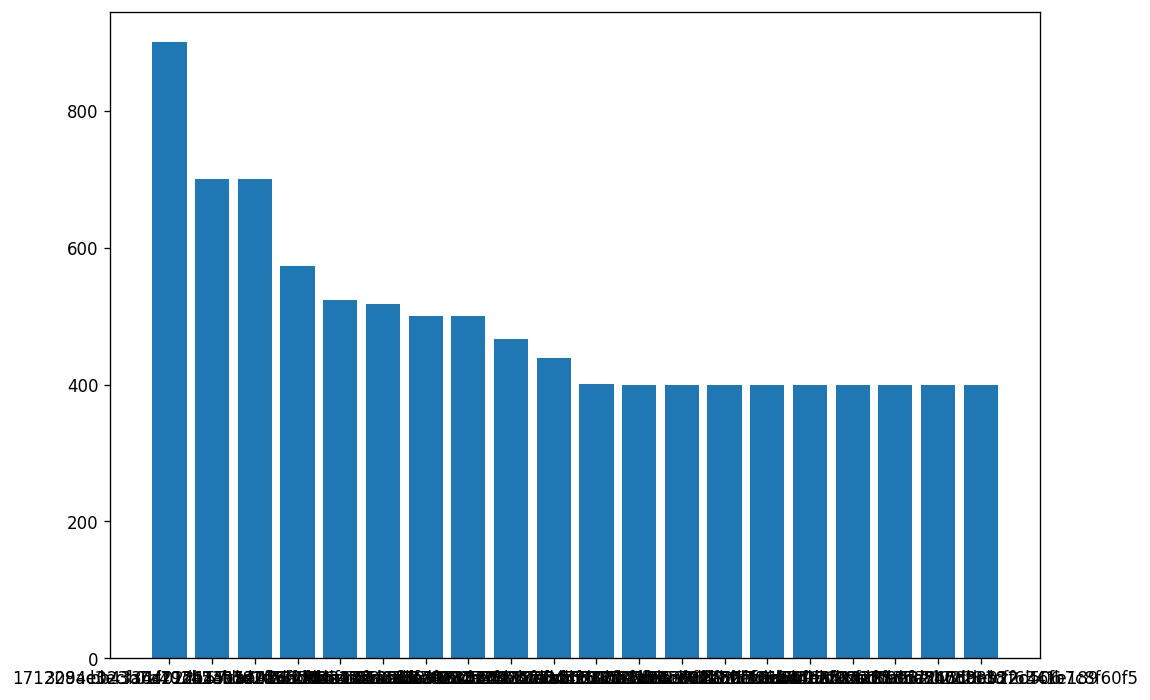

In [208]:
# Horizontal Bar Plot
fig = plt.figure(figsize =(10, 7))
plt.bar(account_grouped_sort_fin['account_number'], account_grouped_sort_fin['transaction_amount'])

Observe que el número de cuenta con mayor número de transaciones tiene un total de 900 transaciones exactamente. Además casi que el 50% del TOP 20 tiene un número de transacciones de 400 exactamente. Lo cual es un caso poco usual con un número exacto de transacciones. Además que el número también es redondo para el segundo y tercer número de cuenta on mayor número de transacciones.

##### Analicemos el dueño de la cuenta desde donde se registró la transacción (user).

In [67]:
user_grouped = datos[['user_id','transaction_type','transaction_amount']].groupby(['user_id','transaction_type']).count().reset_index()
user_grouped_sort = user_grouped.sort_values(by=['transaction_amount'], ascending=False)
user_grouped_sort_fin = user_grouped_sort.loc[user_grouped_sort['transaction_type']=='DEBITO'].head(20)
user_grouped_sort_fin

,user_id,transaction_type,transaction_amount
37689,0457e033945b37b94d7f396aa07daaa1,DEBITO,900
1283786,93bb7c11b0b58e233f56f50cd70c1a82,DEBITO,700
1154161,84d55acc72d398e26fc939d06d17fdb4,DEBITO,700
1110866,7fda354dbc3e684bf414d3ab27208d79,DEBITO,573
20257,025884337f6fe6a70fbb35c58fd798ed,DEBITO,524
1972953,e2d6158cc2b6467a47223cb2629f03f3,DEBITO,517
1838158,d3720205290ca7444d216167dd4cb0b1,DEBITO,513
627252,483525c557cb54274c1a68438e0ebe45,DEBITO,500
1377810,9e925b3e2159cc6d6a4b33ab0a354748,DEBITO,500
820056,5e674596af22a66e826bf15b2a363cce,DEBITO,500


In [69]:
fig = px.bar(user_grouped_sort_fin, x='user_id', y='transaction_amount')
fig.show()

Observe que el comportamiento del TOP 20 es muy similar para el número de transacciones para el número único de cuenta.

### Analicemos los datos agrupados por día para la variables user_id y account_number

##### Para el user_id

In [33]:
# Aggregated information by date and user id. This allows to know the number of transactions by day on every user

dates_group2 = datos[['user_id','date','transaction_amount','transaction_type']].groupby(['user_id','date','transaction_type']).count()
dates_group2 = dates_group2.reset_index()
dates_group2.head(10)


,user_id,date,transaction_type,transaction_amount
0,000002373d5835d0e53b78722424076f,2021-01-26,CREDITO,1
1,000002373d5835d0e53b78722424076f,2021-02-23,CREDITO,1
2,000002373d5835d0e53b78722424076f,2021-04-15,CREDITO,1
3,000004f4a6f3ac93f454a5dc04b2a252,2021-03-10,CREDITO,1
4,000004f4a6f3ac93f454a5dc04b2a252,2021-11-05,DEBITO,1
5,000004f4a6f3ac93f454a5dc04b2a252,2021-11-12,DEBITO,1
6,000004f4a6f3ac93f454a5dc04b2a252,2021-11-16,DEBITO,1
7,000004f4a6f3ac93f454a5dc04b2a252,2021-11-19,DEBITO,1
8,000004f4a6f3ac93f454a5dc04b2a252,2021-11-23,DEBITO,2
9,000004f4a6f3ac93f454a5dc04b2a252,2021-11-25,DEBITO,1


In [ ]:
dates_group2.size

37172352

Observe que al agrupar a nivel de día y usuario podemos notar que hay un total de 37.172.352 registros. Por otro lado, se note que en muchas ocasiones sólo se realiza una transación por día lo cual es un número completamente razonable en el contexto financiero.

Por lo tanto, se filtran la columna "transaction_amount" que contiene la cantidad de transacciones que realizó un usuario en un día.

In [70]:
filtrado1 = dates_group2[dates_group2['transaction_amount']>1]
filtrado1.head(10)

,user_id,date,transaction_type,transaction_amount
8,000004f4a6f3ac93f454a5dc04b2a252,2021-11-23,DEBITO,2
40,0000551498c521d0eb863e006c2a3a5b,2021-11-23,DEBITO,2
69,0000ab49af4f93dbd99c2b3f2e5be578,2021-10-23,DEBITO,2
70,0000ab49af4f93dbd99c2b3f2e5be578,2021-10-29,DEBITO,3
111,0000f85e4d6437a63f4300c3f1c2e3d1,2021-08-17,CREDITO,2
130,000139c60c96114361e626d66609ddeb,2021-03-17,DEBITO,2
146,000175e0ab187e541a564dceb2bae55b,2021-01-13,DEBITO,2
148,000175e0ab187e541a564dceb2bae55b,2021-01-15,DEBITO,2
180,0002444c5640e706f62495b6f0fd202a,2021-11-09,DEBITO,2
182,000247743bc16c6398d33bc05de630c5,2021-02-02,CREDITO,2


In [71]:
filtrado1.size

3623308

Observe que ahora sólo se tienen 3.623.308, menos del 10% de los datos por usuario y fecha.

<Figure size 640x480 with 0 Axes>

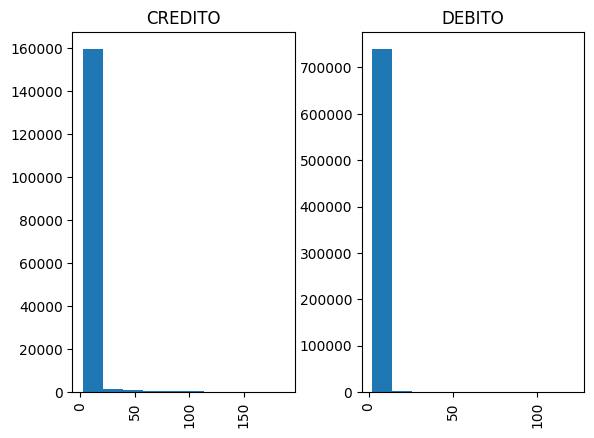

In [76]:
plt.figure()
filtrado1.hist('transaction_amount',by = 'transaction_type')
plt.show()

In [77]:
filtrado1[['transaction_type','transaction_amount']].groupby('transaction_type').quantile([0,0.05,.1, .25, .5, .75,0.9,0.95, 0.99,1])

transaction_amount
transaction_type                         
CREDITO          0.00                 2.0
                 0.05                 2.0
                 0.10                 2.0
                 0.25                 2.0
                 0.50                 2.0
                 0.75                 3.0
                 0.90                 4.0
                 0.95                 4.0
                 0.99                42.0
                 1.00               188.0
DEBITO           0.00                 2.0
                 0.05                 2.0
                 0.10                 2.0
                 0.25                 2.0
                 0.50                 2.0
                 0.75                 2.0
                 0.90                 3.0
                 0.95                 4.0
                 0.99                 5.0
                 1.00               122.0

Note que el 99% del número de las transaciones de naturaleza débito que se realizan en un día por un usuario son inferiores o iguales a 5 transacciones y el 95% de las transacciones de naturaleza crédito son inferiores o iguales a 4 transacciones por día. Por lo tanto, se realiza filtro de nuevo con un número de transacciones al día superiores a 5.

In [78]:
filtrado2 = dates_group2[dates_group2['transaction_amount']>5]
filtrado2[['transaction_type','transaction_amount']].groupby('transaction_type').quantile([0,0.05,.1, .25, .5, .75,0.9,0.95, 0.99,1])

transaction_amount
transaction_type                         
CREDITO          0.00                 6.0
                 0.05                 6.0
                 0.10                 7.0
                 0.25                11.0
                 0.50                26.0
                 0.75                50.0
                 0.90                77.0
                 0.95                93.0
                 0.99               100.0
                 1.00               188.0
DEBITO           0.00                 6.0
                 0.05                 6.0
                 0.10                 6.0
                 0.25                 7.0
                 0.50                18.0
                 0.75                42.0
                 0.90                70.0
                 0.95                85.0
                 0.99               100.0
                 1.00               122.0

<Figure size 640x480 with 0 Axes>

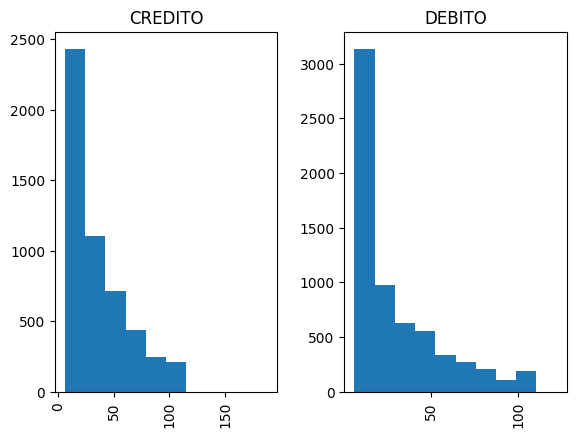

In [79]:
plt.figure()
filtrado2.hist('transaction_amount',by = 'transaction_type')
plt.show()

Observe la distribución asimétrica del número de transacciones por día de cada usuario. Sin embargo, se aprecia que hay una cantidad de transacciones muy por fuera de lo normal respecto a la distribución. Una manera de determinar estos posibles valores es usando el boxplot y determinando valores outlier los cuales son aquellos que están por encima del tercer cuartil + 1.5 el rango intercuartílico, es decir aquellos que distan mucho de la distribuión de los datos.

In [80]:
fig = px.box(filtrado2, x = "transaction_type", y="transaction_amount", points="outliers")
fig.show()

<Axes: xlabel='transaction_type', ylabel='transaction_amount'>

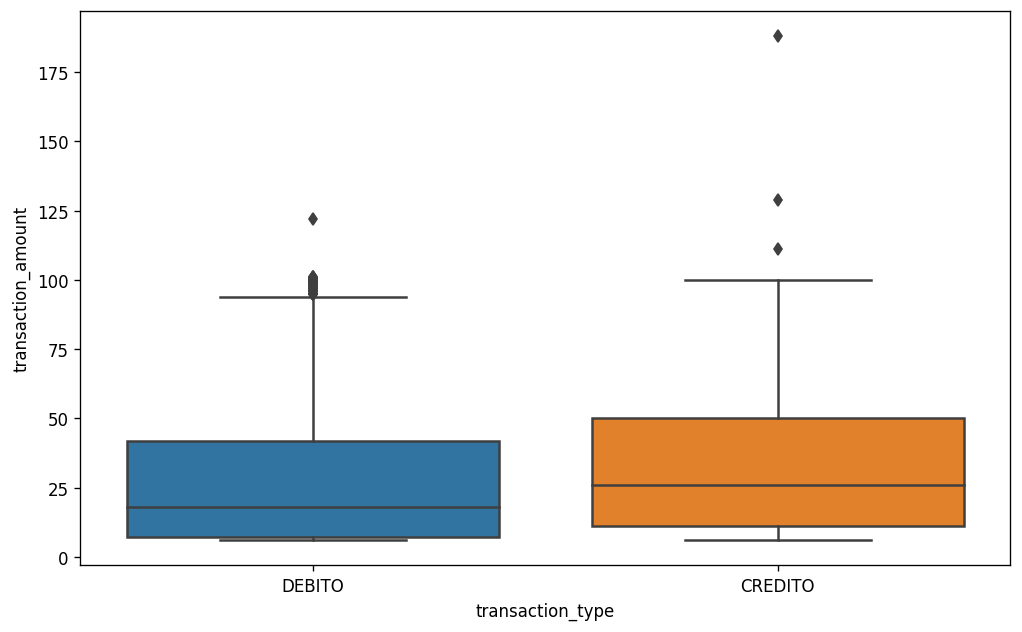

In [210]:
sns.boxplot(x='transaction_type', y='transaction_amount', data=filtrado2)

In [102]:
filtrado2[filtrado2['transaction_amount']>94].size

1896

Note que en la gráfica anterior se observa un total de **1896 datos outliers**, es decir, datos atípicos. Donde el menor número de transacciones de esta distribución es de 95 y el máximo de 122 para el caso de la naturaleza débito.

Sin embargo cabe resaltar que el número de transacciones por día inferior a 18 representa el 50% de dicha cantidad.

### Análisis de datos para datos agrupados monto y número de transacciones para cada usuario


In [90]:
grouped_id_user = datos.groupby(['user_id','date','transaction_type']).agg({'transaction_amount': ['mean','median','std', 'min', 'max','count','sum']})
grouped_id_user.columns = ['ValorProm','ValorMedian','ValorDesvEst', 'ValorMin', 'ValorMax', 'Cantidad','ValorT']
grouped_id_user = grouped_id_user.reset_index()
grouped_id_user.head(10)


,user_id,date,transaction_type,ValorProm,ValorMedian,ValorDesvEst,ValorMin,ValorMax,Cantidad,ValorT
0,000002373d5835d0e53b78722424076f,2021-01-26,CREDITO,29.722275,29.722275,NaN,29.722275,29.722275,1,29.722275
1,000002373d5835d0e53b78722424076f,2021-02-23,CREDITO,71.333460,71.333460,NaN,71.333460,71.333460,1,71.333460
2,000002373d5835d0e53b78722424076f,2021-04-15,CREDITO,23.777820,23.777820,NaN,23.777820,23.777820,1,23.777820
3,000004f4a6f3ac93f454a5dc04b2a252,2021-03-10,CREDITO,594.445501,594.445501,NaN,594.445501,594.445501,1,594.445501
4,000004f4a6f3ac93f454a5dc04b2a252,2021-11-05,DEBITO,178.333650,178.333650,NaN,178.333650,178.333650,1,178.333650
5,000004f4a6f3ac93f454a5dc04b2a252,2021-11-12,DEBITO,47.555640,47.555640,NaN,47.555640,47.555640,1,47.555640
6,000004f4a6f3ac93f454a5dc04b2a252,2021-11-16,DEBITO,11.888910,11.888910,NaN,11.888910,11.888910,1,11.888910
7,000004f4a6f3ac93f454a5dc04b2a252,2021-11-19,DEBITO,713.334601,713.334601,NaN,713.334601,713.334601,1,713.334601
8,000004f4a6f3ac93f454a5dc04b2a252,2021-11-23,DEBITO,41.611185,41.611185,8.406729,35.666730,47.555640,2,83.222370
9,000004f4a6f3ac93f454a5dc04b2a252,2021-11-25,DEBITO,118.889100,118.889100,NaN,118.889100,118.889100,1,118.889100


Se observa que muchs usuarios realizaron una sola transacción en el día, por lo tanto se filtra de la misma manera usada anteriormente, es decir, a partir de 5 transacciones para realizar el análisis.

In [91]:
grouped_id_user_filt = grouped_id_user[grouped_id_user['Cantidad']>5]
grouped_id_user_filt.head(10)

,user_id,date,transaction_type,ValorProm,ValorMedian,ValorDesvEst,ValorMin,ValorMax,Cantidad,ValorT
1582,000b695ceecc41213967b6b3edc96fe5,2021-06-21,DEBITO,71.333460,41.611185,83.392039,23.777820,237.778200,6,428.000761
4339,001ef5cba1bfcd9853731c2b9c76e108,2021-11-24,DEBITO,172.389195,172.389195,67.985441,95.111280,237.778200,6,1034.335172
4342,001ef5cba1bfcd9853731c2b9c76e108,2021-11-30,DEBITO,254.762358,297.222751,107.408290,11.888910,309.111661,7,1783.336504
7767,0038a1319e3a8eff92f88f7e84c7ddb1,2021-02-01,CREDITO,7.212605,6.182233,2.523886,6.182233,12.364466,6,43.275632
9646,00478df24624f43c6424012951344a5a,2021-05-11,DEBITO,95.111280,23.777820,110.509321,23.777820,237.778200,6,570.667681
9992,004a63b9c469d2bfc7e3ce29c3edd462,2021-02-10,DEBITO,6.063344,6.063344,0.000000,6.063344,6.063344,40,242.533764
9993,004a63b9c469d2bfc7e3ce29c3edd462,2021-02-11,DEBITO,7.051038,7.133346,0.290769,6.063344,7.133346,26,183.326992
9994,004a63b9c469d2bfc7e3ce29c3edd462,2021-02-15,CREDITO,7.133346,7.133346,0.000000,7.133346,7.133346,12,85.600152
10846,0051fb4a9899749ec117a82ac8b505a6,2021-03-30,DEBITO,535.000951,713.334601,278.819655,118.889100,713.334601,6,3210.005707
15756,0075eb52b56c2043d33a31a1a738935d,2021-05-03,DEBITO,146.629890,59.444550,222.124381,23.777820,594.445501,6,879.779342


Note en la tabla anterior que existen casos donde el valor promedio y valor mediano son idénticos, por lo tanto se revisa la desviación estándar y nos muestra que es de **cero** valor moneda ficticia. Esto nos dice que todas las transacciones realizadas fueron por el mismo valor, una conducta muy inusual a nivel transaccional, por lo cual se extren como usuarios sospechosos.

In [123]:
sospechosos_user = grouped_id_user_filt[(grouped_id_user_filt['ValorDesvEst']==0) & (grouped_id_user_filt['Cantidad']>94)]
sospechosos_user.head(20)

,user_id,date,transaction_type,ValorProm,ValorMedian,ValorDesvEst,ValorMin,ValorMax,Cantidad,ValorT
84319,025884337f6fe6a70fbb35c58fd798ed,2021-02-04,DEBITO,5.944455,5.944455,0.0,5.944455,5.944455,98,582.556591
84321,025884337f6fe6a70fbb35c58fd798ed,2021-02-08,DEBITO,5.944455,5.944455,0.0,5.944455,5.944455,100,594.445501
98522,02bb2479b4fe6c8119254eaacc88ba7e,2021-01-22,DEBITO,5.944455,5.944455,0.0,5.944455,5.944455,100,594.445501
423898,0bb46e2bc60074ff5301a35859ae5c5e,2021-02-05,DEBITO,5.944455,5.944455,0.0,5.944455,5.944455,100,594.445501
432603,0bf05521ced57d38c8e6ed2175b13b50,2021-02-03,DEBITO,5.944455,5.944455,0.0,5.944455,5.944455,98,582.556591
634039,11819f750f3c06ad65ca287ede9be823,2021-02-04,CREDITO,5.944455,5.944455,0.0,5.944455,5.944455,100,594.445501
767257,15363fd8b66e0fe82b9f41b03ca40a41,2021-01-27,CREDITO,5.944455,5.944455,0.0,5.944455,5.944455,100,594.445501
1031365,1c7b3c59763b38a5a6e8ce2e2ebe3a67,2021-01-25,DEBITO,7.133346,7.133346,0.0,7.133346,7.133346,95,677.667871
1053745,1d1ac29df824deabcf513db3183e006a,2021-02-06,DEBITO,5.944455,5.944455,0.0,5.944455,5.944455,100,594.445501
1071920,1d9b766cb2d8aca55243c444a8ff5108,2021-02-03,DEBITO,5.944455,5.944455,0.0,5.944455,5.944455,96,570.667681


In [124]:
sospechosos_user[sospechosos_user['transaction_type']=='DEBITO'].size

1000

Note que hay un total de **1000 registros** por día de naturaleza débito en el cual todas las transacciones tienen el mismo valor y por tanto varianza o desviación estándar 0.

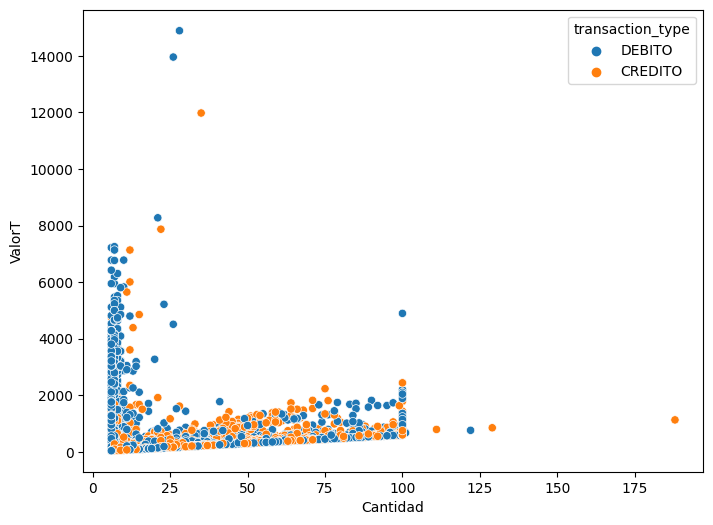

In [106]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='Cantidad', y='ValorT', hue='transaction_type', data=grouped_id_user_filt)
plt.show()

Analizamos para el caso de merchant_id, subsidiary and id_user.

In [126]:
grouped_id_user_filt_deb = grouped_id_user_filt[grouped_id_user_filt['transaction_type'] == 'DEBITO']
grouped_id_user_filt_deb.head(10)

,user_id,date,transaction_type,ValorProm,ValorMedian,ValorDesvEst,ValorMin,ValorMax,Cantidad,ValorT
1582,000b695ceecc41213967b6b3edc96fe5,2021-06-21,DEBITO,71.333460,41.611185,83.392039,23.777820,237.778200,6,428.000761
4339,001ef5cba1bfcd9853731c2b9c76e108,2021-11-24,DEBITO,172.389195,172.389195,67.985441,95.111280,237.778200,6,1034.335172
4342,001ef5cba1bfcd9853731c2b9c76e108,2021-11-30,DEBITO,254.762358,297.222751,107.408290,11.888910,309.111661,7,1783.336504
9646,00478df24624f43c6424012951344a5a,2021-05-11,DEBITO,95.111280,23.777820,110.509321,23.777820,237.778200,6,570.667681
9992,004a63b9c469d2bfc7e3ce29c3edd462,2021-02-10,DEBITO,6.063344,6.063344,0.000000,6.063344,6.063344,40,242.533764
9993,004a63b9c469d2bfc7e3ce29c3edd462,2021-02-11,DEBITO,7.051038,7.133346,0.290769,6.063344,7.133346,26,183.326992
10846,0051fb4a9899749ec117a82ac8b505a6,2021-03-30,DEBITO,535.000951,713.334601,278.819655,118.889100,713.334601,6,3210.005707
15756,0075eb52b56c2043d33a31a1a738935d,2021-05-03,DEBITO,146.629890,59.444550,222.124381,23.777820,594.445501,6,879.779342
18514,00897a7d3555bb00d4b80596dbf668a6,2021-03-07,DEBITO,8.322237,8.322237,2.009593,5.944455,10.700019,8,66.577896
18516,00897a7d3555bb00d4b80596dbf668a6,2021-03-08,DEBITO,10.204648,9.511128,3.341929,5.944455,17.833365,12,122.455773


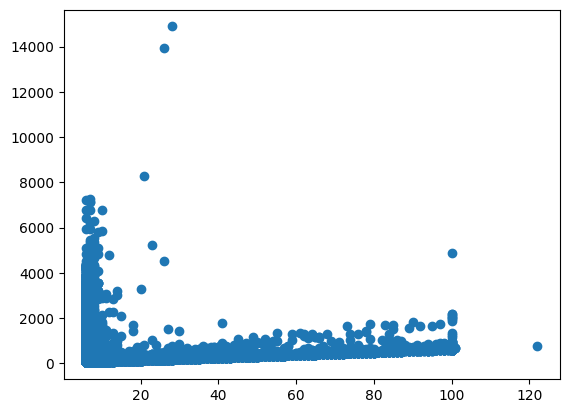

In [127]:
plt.plot(grouped_id_user_filt_deb['Cantidad'], grouped_id_user_filt_deb['ValorT'], "o")
plt.show()

# 4. Generación de distancias a través de distancia de Mahalanobis

## Análisis de outliers usando estadística multivariada (distancia de Mahalanobis)

In [129]:
# the Mahalanobis distance
def calculateMahalanobis(y=None, data=None, cov=None):

    y_mu = y - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()

In [ ]:
# calculate mahalanobis distance for each obs

grouped_id_user_filt_deb['calculateMahalanobis'] = calculateMahalanobis(y=grouped_id_user_filt_deb[['Cantidad','ValorT']], data=grouped_id_user_filt_deb[['Cantidad','ValorT']])

# calculate p-value for each mahalanobis distance
grouped_id_user_filt_deb['p'] = 1 - chi2.cdf(grouped_id_user_filt_deb['calculateMahalanobis'], 3)

<Figure size 640x480 with 0 Axes>

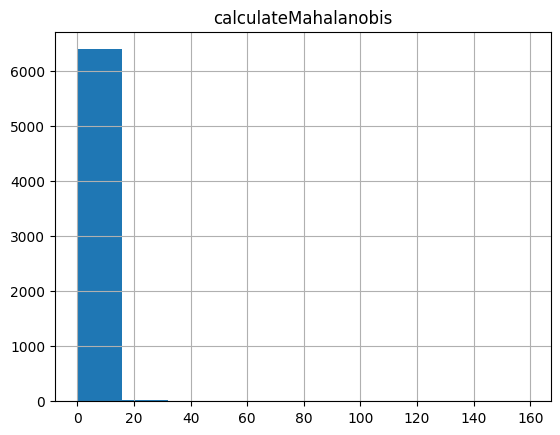

In [133]:
#grouped_id_user_filt_deb['calculateMahalanobis']
plt.figure()
grouped_id_user_filt_deb.hist('calculateMahalanobis')
plt.show()

In [139]:
sospechosos_maha = grouped_id_user_filt_deb[grouped_id_user_filt_deb['p']<0.05]
sospechosos_maha.head(10)

,user_id,date,transaction_type,ValorProm,ValorMedian,ValorDesvEst,ValorMin,ValorMax,Cantidad,ValorT,calculateMahalanobis,p
62457,01c2e0350f7d77f4084502861b4989ff,2021-01-31,DEBITO,5.946773,5.946833,0.000961,5.945644,5.948022,100,594.677335,7.962034,0.046803
62459,01c2e0350f7d77f4084502861b4989ff,2021-02-05,DEBITO,5.946868,5.946833,0.000992,5.945644,5.948022,100,594.686846,7.962043,0.046803
84316,025884337f6fe6a70fbb35c58fd798ed,2021-01-27,DEBITO,5.968233,5.944455,0.237778,5.944455,8.322237,100,596.823283,7.964113,0.046759
84321,025884337f6fe6a70fbb35c58fd798ed,2021-02-08,DEBITO,5.944455,5.944455,0.000000,5.944455,5.944455,100,594.445501,7.961810,0.046808
98522,02bb2479b4fe6c8119254eaacc88ba7e,2021-01-22,DEBITO,5.944455,5.944455,0.000000,5.944455,5.944455,100,594.445501,7.961810,0.046808
137452,03d0962321992eecbdebaef646d168ad,2021-02-02,DEBITO,5.945680,5.945644,0.000977,5.944455,5.946833,100,594.567957,7.961928,0.046805
142077,03f0a2b30f6d7e46bf8b5f530beaed5e,2021-01-24,DEBITO,673.704901,713.334601,97.072544,475.556401,713.334601,6,4042.229408,8.166286,0.042697
147870,04186493809f56eaab5ba1dca36047e4,2021-01-03,DEBITO,5.945549,5.944455,0.001191,5.944455,5.946833,100,594.554879,7.961915,0.046805
157282,0457e033945b37b94d7f396aa07daaa1,2021-01-19,DEBITO,8.174815,7.133346,2.175281,5.944455,17.833365,100,817.481453,8.217129,0.041731
157286,0457e033945b37b94d7f396aa07daaa1,2021-01-23,DEBITO,7.439576,7.133346,1.566699,5.944455,10.700019,99,736.517976,7.890742,0.048325


In [140]:
sospechosos_maha.size

3708

Observe que usando un nivel de significancia del 5% se tiene un total de 3708 registros como sospechosos de mala práctica. Note además que varios de ellos tienen un valor desviación estándar cercanos a cero.

## Análisis de la cantidad de registros por día y monto total para los usuarios usando Kmeans como método de aprendizaje no supervisado.

In [185]:
datos_cluster =  grouped_id_user_filt_deb[['Cantidad','ValorT']].to_numpy()


In [163]:
scaler = preprocessing.StandardScaler().fit(datos_cluster)

X_scaled = scaler.transform(datos_cluster)

In [ ]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]


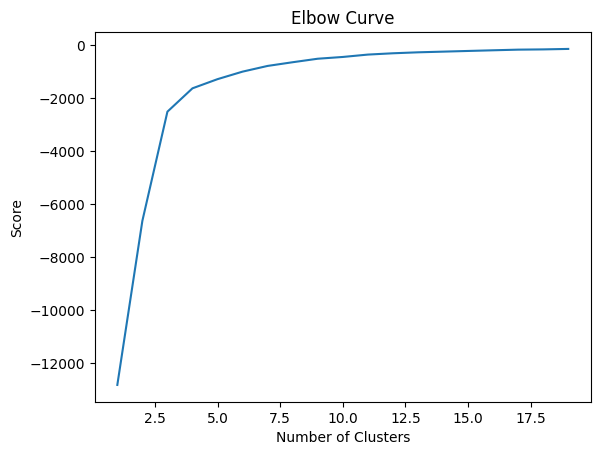

In [179]:
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Se observa con el gráfico de codo que a partir de 7-8 grupos no hay gran cambio en la variabilidad. Por lo tanto, se usarán 7 grupos o clústers

In [ ]:
kmeans = KMeans(n_clusters=7).fit(X_scaled)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X_scaled)


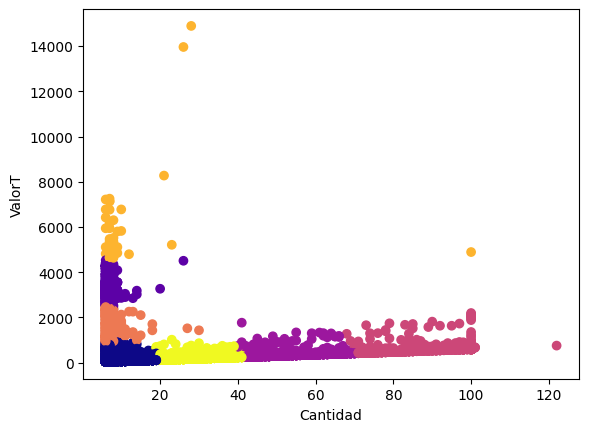

In [188]:
plt.scatter(datos_cluster[:, 0], datos_cluster[:,1], c = labels, cmap= "plasma") # plotting the clusters
plt.xlabel("Cantidad") # X-axis label
plt.ylabel("ValorT") # Y-axis label
plt.show()

Observe que usando un número de 7 clúster se siguen observando agrupaciones de valores totales pequeños o relativamente pequeños. Sin embargo para un número de transacciones por día altas.

# 5. Determinación de frecuencia

Para determinar la fecuencia se realiza un análisis de series de tiempo, donde se estudia a través de la ACF y PACF el nivel de autocorrelación y los rezagos en dicha serie.

In [194]:
datos_bed = dates_group[dates_group['transaction_type'] == 'DEBITO'].reset_index()
datos_bed

,date,transaction_type,Number_Transaction_by_day
0,2021-01-01,DEBITO,6107
1,2021-01-02,DEBITO,13960
2,2021-01-03,DEBITO,12726
3,2021-01-04,DEBITO,22471
4,2021-01-05,DEBITO,21931
...,...,...,...
329,2021-11-26,DEBITO,35238
330,2021-11-27,DEBITO,33560
331,2021-11-28,DEBITO,26529
332,2021-11-29,DEBITO,33016


In [191]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [ ]:
multiplicative_decomposition = seasonal_decompose(datos_bed['Number of Passengers'], model='multiplicative', period=7)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

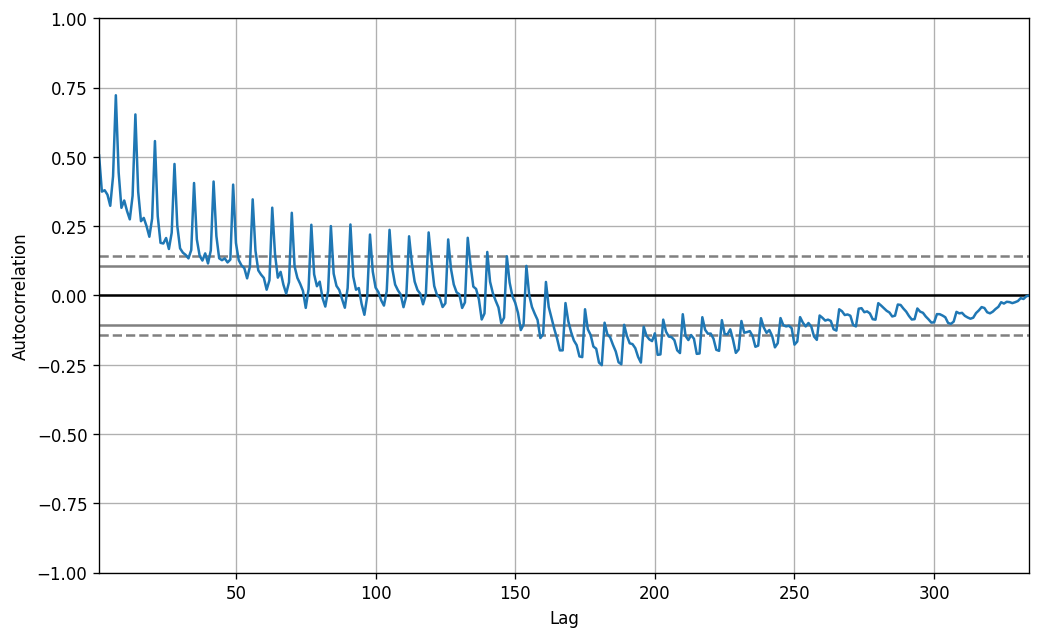

In [195]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(datos_bed['Number_Transaction_by_day'].tolist())

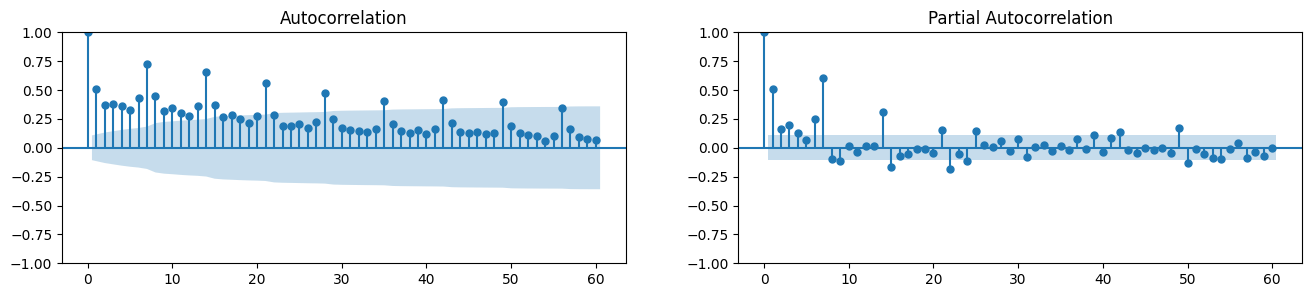

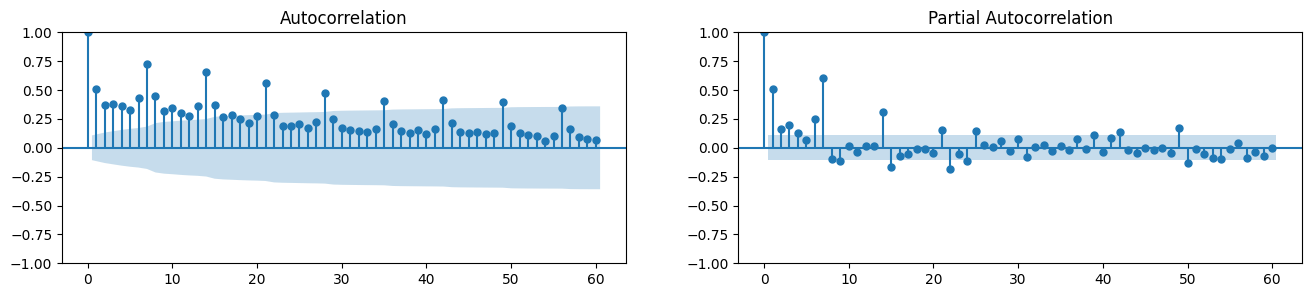

In [203]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(datos_bed['Number_Transaction_by_day'].tolist(), lags=60, ax=axes[0])
plot_pacf(datos_bed['Number_Transaction_by_day'].tolist(), lags=60, ax=axes[1])

Observe que al igual que se mencionó en el inicio del documento, se aprecia que existe una estacionalidad semanal del proceso, además de un decaimiento lento respecto a la correlación de los rezagos de la semana anterior. Por lo tanto, se sugiere que este análisis se realice de manera semanal.

# Conclusiones y hallazgos.



1.   Durante el proceso de análisis descriptivo de los datos se encontraron los siguientes hallazgos:

  * Se encontró una buena calidad de información debido a que el número de datos faltantes es 0.
  * Sólo se registraron en los datos 3 comercios o aliados
  * Se encontraron una cantidad de transacciones redondas, es decir, 900, 700, 400 para las cuentas o usuarios.
  * El número de tranacciones por día de un usuario en un 99% suelen ser inferiores a 5.
  * Se lograron identificar 1000 registros donde TODAS las transacciones realizadas en ese día fueron del mismo valor dado que la variación fue cero para las de naturaleza débito (este tipo de conductas es sospechosa)
  * Usando el boxplot se determinó de manera marginal que el número de transacciones en un día de un cliente superiores o iguales a 95, era considerado un outlier para las transacciones de tipo débito.

2.   Durante el análisis usando estadística multivariada:

  * Se observó que 3708 registros se podrían considerar atípicos usando la distancia de Mahalanobis entre la cantidad de registros en un día de un usuario y su monto total.
  * Se apreció que realizando un análisis con un modelo de aprendizaje no supervisado, un número de 7 grupos permitía representar ciertos grupos e identificaba uno de ellos como un grupo con un número alto de transacciones, con montos de valor relativamente bajos.

3. Determinación de la frecuencia de ejecución del modelo.

  * Inspeccionando a través de una análisis de series de tiempo mediante la ACF y PACF se observó una estacionalidad semanal usando los rezagos.



### **Proceso para el modelo.**

Pasos para realizar el modelo:



1.   Importar la información disponible.
2.   Crear las variables de fecha a nivel de día y valor como flotante.
3.   Se agrupa a nivel de usuario, día y tipo de transacción para realizar el conteo de transacciones y así tener el número de transacciones por día de cada usuario
4.   Se filtran los datos con el 1% superior de la distribución de lacantidad de transacciones por día.
5.   Se generan el boxplot y se calculan los outlier usando la distancia intecuartílico y así se obtienen unas posibles transacciones suceptibles a malas prácticas
6.   Con los datos agrupados, se puede tener el valor de la media, mediana, desviación estándar, cantidad de transacciones y se filtran aquellas transacciones donde la desviación estándar es 0 y el número de transacciones estápor fuera del límite superior en el boxplot, dado que es un indicador de que todas lastransacciones se hicieron por un mismo valor.
7. De manera independiente se realiza una normalización de los datos de tipo de transacción débito con la cantidad y monto total para calcular la distancia de Mahalanobis y posteriormente compararla con una distribución chi-cuadrado y buscar aquellas que sean significativas a un 5% de significancia.


La decisión o criterio final debe ser concensuada con el negocio. Sin embargo, se tienen dos métodos basados en estadística descriptiva y estadística multivariada en función de las distancias. Un modelo es de manera marginal, el segundo es bivariado y con soporte estadístico usando una distribución chi-cuadrado como respaldo. El método de K-means es visual y al no ser supervisado puede que cambie en el siguiente conjunto de datos a realizar


A continuación se presenta el Diagrama de Flujo de Datos (DFD) del modelo para la detección de malas prácticas transaccionales.



### **Diagrama de Flujo de Datos**

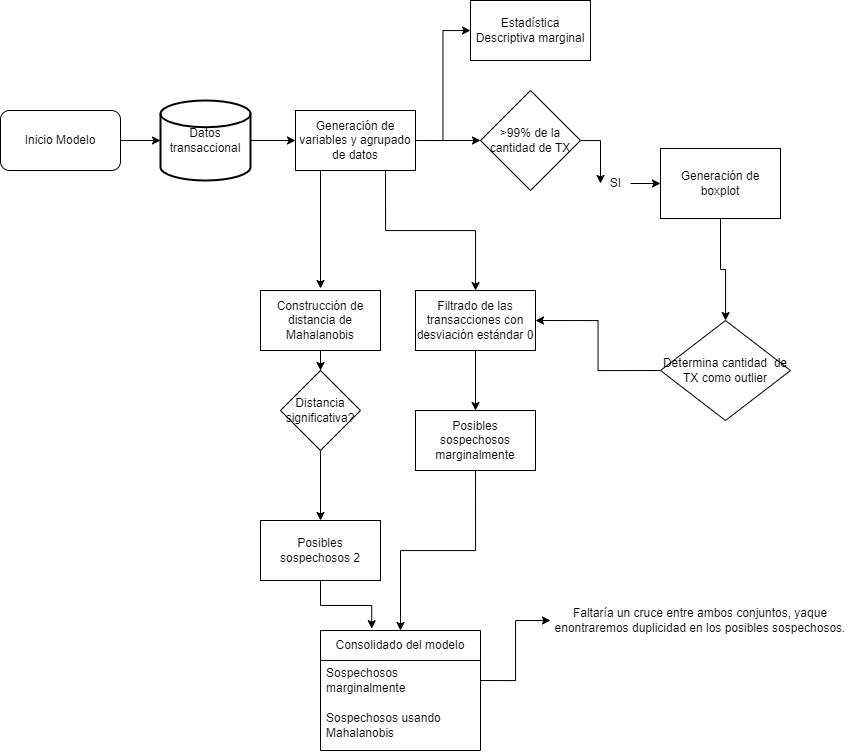